In [79]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.suction_based_grasping.utils import *
from src.suction_based_grasping.convnet.model import *
from src.suction_based_grasping.convnet.data_utils import *
from src.suction_based_grasping.convnet.evaluate import *

from keras import models # for load_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# X_target_shape = (960, 1280) # height and width of inputs to ResNet50
X_target_shape = (480, 640) # height and width of inputs to ResNet50
y_target_shape = (480, 640)
model_filepath = '/home/shared/project/src/suction_based_grasping/convnet/models'

In [29]:
# load test/train data
X_train, X_test, y_train, y_test = train_test_split("train-split.txt", "test-split.txt", num_train=1s, num_test=20, X_target_shape=X_target_shape, y_target_shape=y_target_shape)

Loading Training Data from train-split.txt


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Done!00	100.00%
Loading Test Data from test-split.txt
Done!	100.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


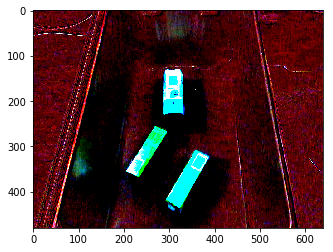

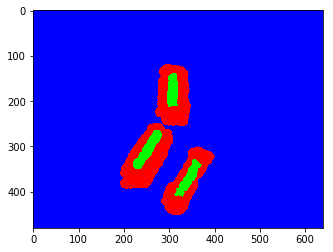

In [31]:
plt.imshow(X_train[0][0])
plt.figure()
plt.imshow(y_train[0])

In [30]:
model = init_model(X_target_shape, y_target_shape)

In [ ]:
train_batch_size = 100
val_batch_size = 20

img_names = read_split_file("train-split.txt")
N = len(img_names)
validation_split = 0.2
N_train = int((1-validation_split)*N)
N_val = N-N_train
train_img_names = img_names[0:N_train]
val_img_names = img_names[N_train:N]

model.fit_generator(
    image_generator(train_img_names, train_batch_size, X_target_shape=X_target_shape, y_target_shape=y_target_shape),
    validation_data=image_generator(val_img_names, val_batch_size, X_target_shape=X_target_shape, y_target_shape=y_target_shape),
    validation_steps=1,
    steps_per_epoch=2, epochs=1, verbose=2)

Epoch 1/10


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [38]:
# save model
model_name = 'model_f'
model.save(os.path.join(model_filepath, model_name))

In [7]:
# load model
model_name = 'model_b'
model = models.load_model(os.path.join(model_filepath, model_name), custom_objects={'heatmap_loss': heatmap_loss})

In [32]:
# fit model to real data
model.fit(x=X_train, y=y_train, epochs=1, batch_size=2, validation_split=0.2, verbose=2)

Train on 80 samples, validate on 20 samples
Epoch 1/1
 - 258s - loss: 0.8785 - acc: 0.8371 - val_loss: 0.6501 - val_acc: 0.8337


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


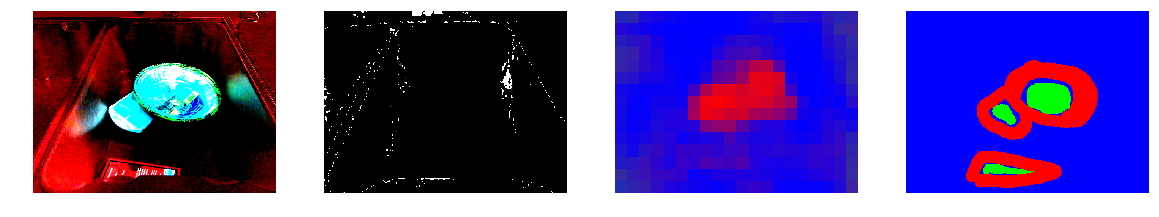

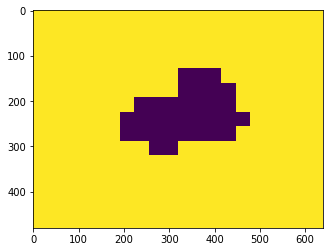

In [77]:
# test prediction
img_idx = 99
color = X_train[0][np.newaxis, img_idx]
depth = X_train[1][np.newaxis, img_idx]
heatmap = model.predict([color, depth])[0]

plt.figure(figsize=(20, 50))
plt.subplot(1, 4, 1)
plt.axis('off')
plt.imshow(X_train[0][img_idx])
plt.subplot(1, 4, 2)
plt.axis('off')
plt.imshow(X_train[1][img_idx])
plt.subplot(1, 4, 3)
plt.axis('off')
plt.imshow(heatmap) # remove minibatch dim
plt.subplot(1, 4, 4)
plt.axis('off')
plt.imshow(y_train[img_idx])

plt.figure()
plt.imshow(np.argmax(heatmap, axis=2)/2.)

In [85]:
evaluate(model, X_target_shape, y_target_shape, num_imgs=50)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


sum_tp=12541183 sum_fp=710256 sum_tn=685456 sum_fn=710256
Precision: 0.898089684200154
Recall: 0.9464015945739931


In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_color (InputLayer)      (None, 960, 1280, 3) 0                                            
__________________________________________________________________________________________________
input_2_depth (InputLayer)      (None, 960, 1280, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad_color (ZeroPadding2D) (None, 966, 1286, 3) 0           input_1_color[0][0]              
__________________________________________________________________________________________________
conv1_pad_depth (ZeroPadding2D) (None, 966, 1286, 3) 0           input_2_depth[0][0]              
__________________________________________________________________________________________________
conv1_colo